In [1]:
from __future__ import print_function, division
import os
import sys
import time 

import emcee
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pickle
from scipy.optimize import curve_fit

from toggle_equations import *
from attractor_stats import *
from steady_states import *
from sim_funcs import *
from plotting_funcs import *


ModuleNotFoundError: No module named 'emcee'

# Importing data to initialise run

`mcmc_initialise.csv`: Excel file that contains the normalised values of Sox2, Tbxta and TCF_mRNA of an 18ss TCF-GFP tailbud. 

Filename of sample: TCF-GFP_18ss_B1tbxta594_B4sox2647_B2egfp546_4_Series009.ims

NMp number = 182

In [10]:
##### df = pd.read_csv("normalised_exp.csv")
df = pd.read_csv("files/csv/mcmc_initialise.csv")
data = np.load("files/npy/loess_fit_vals_050421.npy")
#filt = (df["stage"] == "18ss") & (df["ID"] == 7)
nmp_numbers = len(df)
"""
groups = df.loc[filt, ].groupby("ID")
for _ , group in groups:
    nmp_list = group[["sox2_norm", "tbxta_norm", "tcf_norm"]].values.tolist()
"""

nmp_list = df[['sox2_norm', 'tbxta_norm']].values.tolist()
nmp_list_tcf = df[['sox2_norm', 'tbxta_norm','tcf_norm', 'TCF_group']].values.tolist()

In [13]:
mylist = [l for l in nmp_list_tcf if l[3] == 0]
len(mylist)

60

In [4]:
nmp_list_tcf

[[0.360546782606608, 0.33999913174345897, 0.49255643564356394, 1.0],
 [0.136614642376552, 0.142272516786293, 0.44234851485148496, 1.0],
 [0.0022842615479472398, 0.289887705487381, 0.361341584158416, 1.0],
 [0.0167444172357735, 0.13319923593424401, 0.305214356435644, 1.0],
 [0.0892862232725647, 0.18254514934012497, 0.29348861386138597, 1.0],
 [0.0484215442668186, 0.0673694721000232, 0.420704455445545, 1.0],
 [0.20611309994994398, 0.21186183144246398, 0.534039603960396, 1.0],
 [0.0201958124205222, 0.127264702477425, 0.585712871287129, 1.0],
 [0.0282417336785062, 0.20639326232924302, 0.551816831683168, 1.0],
 [0.0287867960881521, 0.21359689742996105, 0.42941386138613896, 1.0],
 [0.0152667480426509, 0.28986744616809396, 0.40976435643564396, 1.0],
 [0.0965945600771289, 0.134669483676777, 0.286610891089109, 0.0],
 [0.0953894220888292, 0.0411481245658717, 0.237076237623762, 0.0],
 [0.121361895937085, 0.094022053716138, 0.358061881188119, 0.0],
 [0.13895341016546398, 0.347962491317435, 0.24055

(array([26., 40., 37., 24., 18., 16., 11.,  6.,  1.,  3.]),
 array([0.12108168, 0.18168193, 0.24228218, 0.30288243, 0.36348267,
        0.42408292, 0.48468317, 0.54528342, 0.60588366, 0.66648391,
        0.72708416]),
 <a list of 10 Patch objects>)

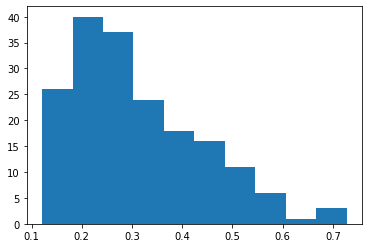

In [6]:
plt.hist(df.tcf_norm)

# Defining parameters

In [22]:
num_ss = 100
dt = .1  # Time step.
T = 10  # Total time.
tolerance = 1e-8
max1 = 1
max2 = 1
n = int(T / dt)
t = np.linspace(0., T, n)  # Vector of times.
sim_stages = np.linspace(0,n-1,num_ss, dtype = int)


In [23]:
x_vals = [0, n]
y_vals = [x, 0]
coefs = np.polyfit(x_vals,y_vals,5)
xf=np.linspace(0,n,n)
new_line = np.polyval(coefs, xf)
plt.scatter(xf,new_line,c='g', marker='^', s=5)


NameError: name 'x' is not defined

In [ ]:
def em_cle_tcf_alpha1 (n_traj, x_init, y_init, tolerance, dt , T, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, tcf_init, tcf_group, seed = 20):
    np.random.seed(seed)
    n = int(T / dt)
    t = np.linspace(0., T, n)
    sqrtdt =  np.sqrt(dt/omega) 
    x = np.zeros((n_traj,2,n))
    x[:,:,0]= [x_init,y_init]
    diverging_time = n/3
    
    # Euler-Marayama method
    for k in range(n_traj):
        if tcf_group == 0:
            x_vals = [0, n]
            y_vals = [tcf_init, 0]
            coefs = np.polyfit(x_vals,y_vals,5)
            xf=np.linspace(0,n,n)
            alpha_vals = np.polyval(coefs, xf)
            
            for i in range(n - 1):
                pp = protein_production([x[k][0][i], x[k][1][i]],alpha_vals[i],alpha2,a,c,b,d, max1, max2)
                de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
                detT = deterministic_term(pp,de)
                stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
                x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
                x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

                # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
                if(x[k][0][i + 1] < tolerance):
                    x[k][0][i + 1] = 0
                elif(x[k][1][i + 1] < tolerance):
                    x[k][1][i + 1] = 0
                    
            elif tcf_group == 0:
                x_vals = [0, n]
                y_vals = [tcf_init, 1]
                coefs = np.polyfit(x_vals,y_vals,5)
                xf=np.linspace(0,n,n)
                alpha_vals = np.polyval(coefs, xf)
                
                           
                for i in range(n - 1):
                    pp = protein_production([x[k][0][i], x[k][1][i]],alpha_vals[i],alpha2,a,c,b,d, max1, max2)
                    de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
                    detT = deterministic_term(pp,de)
                    stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
                    x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
                    x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

                    # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
                    if(x[k][0][i + 1] < tolerance):
                        x[k][0][i + 1] = 0
                    elif(x[k][1][i + 1] < tolerance):
                        x[k][1][i + 1] = 0
                        
    return x

# Stoch model

`batch`: Total number of rounds to iterate the entire run. Equivalent to an entire HCR time-course experiment from 18ss to 28ss.

`num_nmps_time`: Number of NMps / nmp_numbers (total number of cells / embryo) / batch calculated at `num_ss` intervals.

`num_nmps_embryos_time`: `num_nmps_time` of all embryos

`batch_nmp_num`: `num_nmps_embryos_time` for all batches.


## Autonomous 

In [24]:
def stoch_model(alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val):
    batch_num = 0
    batch = 1
    batch_nmp_num = [[] for i in range(batch)]

    while batch_num < batch:
        trajs_list = []
        i = 0
        while i < nmp_numbers:
            xinit = nmp_list[i][0]
            yinit = nmp_list[i][1]
            single_cell_sim = em_cle(1, xinit, yinit, tolerance, dt , T, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, seed = batch_num)
            trajs_list.append(single_cell_sim)
            i+=1
        #print("Embryo simulation complete: {} cells".format(nmp_numbers))

        num_nmps_time = []
        for i in range(num_ss) :
            nmp_counter = 0
            traj = np.squeeze(np.array(trajs_list))[:,:,sim_stages[i]]
            for cell in traj:
                if not ((cell[0] <= exit_nmp_val and cell[1] >= exit_nmp_val) or (cell[0] >= exit_nmp_val and cell[1] <= exit_nmp_val)):
                    nmp_counter += 1
            num_nmps_time.append(nmp_counter)
        #print("num_nmps_time", num_nmps_time)
        batch_nmp_num[batch_num].append(num_nmps_time)
        batch_num +=1
    return batch_nmp_num



## TCF model

In [7]:
def stoch_model_tcf(alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val):
    batch_num = 0
    batch = 1
    batch_nmp_num = [[] for i in range(batch)]

    while batch_num < batch:
        trajs_list = []
        i = 0
        while i < nmp_numbers:
            xinit = nmp_list_tcf[i][0]
            yinit = nmp_list_tcf[i][1]
            tcf_init = nmp_list_tcf[i][2]
            tcf_group = nmp_list_tcf[i][3]
            single_cell_sim = em_cle_tcf_alpha1(1, xinit, yinit, tolerance, dt , T, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, tcf_init = tcf_init, tcf_group = tcf_group, seed = batch_num)
            trajs_list.append(single_cell_sim)
            i+=1
        #print("Embryo simulation complete: {} cells".format(nmp_numbers))

        num_nmps_time = []
        for i in range(num_ss) :
            nmp_counter = 0
            traj = np.squeeze(np.array(trajs_list))[:,:,sim_stages[i]]
            for cell in traj:
                if not ((cell[0] <= exit_nmp_val and cell[1] >= exit_nmp_val) or (cell[0] >= exit_nmp_val and cell[1] <= exit_nmp_val)):
                    nmp_counter += 1
            num_nmps_time.append(nmp_counter)
        #print("num_nmps_time", num_nmps_time)
        batch_nmp_num[batch_num].append(num_nmps_time)
        batch_num +=1
    return batch_nmp_num



In [42]:
 md = np.mean(batch_nmp_num, axis = 0)

In [68]:
(((md - data)/0.25)**2)[0][5:].shape

(95,)

In [72]:
np.sum((((md - data)/0.25)**2)[0])

3848738.8647658397

In [44]:
np.sum((((md - data)/0.25)**2)[0][5:])

3769907.693793953

# MCMC functions

In [25]:
# Import data

def logposterior(theta,sigma, x):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, sigma,x)



In [26]:
def loglikelihood(theta, sigma,t):
    alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = theta
    
    batch_nmp_num = stoch_model(alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val)
    md = np.mean(batch_nmp_num, axis = 0)
    return -0.5*np.sum((((md - data)/0.25)**2)[0])



In [27]:
# Add evidence of activation or repression
def logprior(theta):
    alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = theta
    if 0 < alpha1 < 1 and \
       0 < alpha2 < 1  and \
       0  < a < 1  and \
       0 < c <1  and \
       0  < b < 1  and \
       0  < d < 1  and \
       0 < lambda1 < 5 and \
       0  < lambda2 < 5  and \
       10  < omega < 1000  and \
       0 < exit_nmp_val < 0.3:
        lp = 0.
    else:
        lp = -np.inf
    return lp


# Run MCMC model

In [29]:
Nens = 100
# Initial (Nens) points
alpha1_ini = np.random.uniform(0,1, Nens) 
alpha2_ini = np.random.uniform(0,1, Nens) 
a_ini = np.random.uniform(0,1, Nens) 
c_ini = np.random.uniform(0,1, Nens) 
b_ini = np.random.uniform(0,1, Nens) 
d_ini = np.random.uniform(0,1, Nens) 
lambda1_ini = np.random.uniform(0,5, Nens) 
lambda2_ini = np.random.uniform(0,5, Nens) 
omega_ini = np.random.uniform(10,1000, Nens) 
exit_nmp_val_ini = np.random.uniform(0,0.3, Nens) 

inisamples = np.array([alpha1_ini, alpha2_ini, a_ini, \
                       c_ini, b_ini, d_ini,\
                       lambda1_ini, lambda2_ini, omega_ini,\
                       exit_nmp_val_ini]).T

nwalkers, ndim = inisamples.shape
ndims = inisamples.shape[1] 
Nburnin = 0   
Nsamples = 100
dsigma = 0.25
argslist = (dsigma, sim_stages)




### Backend saving

In [ ]:

filename = "test_saving.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim) #In case file name exists already- this clears it.


### Multiprocessing 

In [16]:
with Pool() as pool:
    start = time.time()
    sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args = argslist, pool = pool, moves = emcee.moves.StretchMove(a = 1.3))
    sampler.run_mcmc(inisamples, Nsamples+Nburnin, progress=True)
    end = time.time()
    time_taken = end - start
    print("One run took {0:.1f} seconds".format(time_taken))
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))


100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.87s/it]

One run took 36.3 seconds


### MPI

In [14]:
from schwimmbad import MPIPool

with MPIPool() as pool:
    if not pool.is_master():
        pool.wait()
        sys.exit(0)
    np.random.seed(42)

    inisamples = np.array([alpha1_ini, alpha2_ini, a_ini, \
                           c_ini, b_ini, d_ini,\
                           lambda1_ini, lambda2_ini, omega_ini,\
                           exit_nmp_val_ini]).T

    nwalkers, ndim = inisamples.shape
    ndims = inisamples.shape[1] 
    Nburnin = 0   
    Nsamples = 3
    dsigma = 0.25
    argslist = (dsigma, sim_stages)
    np.random.seed(42)
    initial = np.random.randn(32, 5)
    nwalkers, ndim = initial.shape
    nsteps = 100

    start = time.time()
    sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args = argslist, pool = pooL)
    sampler.run_mcmc(inisamples, Nsamples+Nburnin, progress=True)
    end = time.time()
    time_taken = end - start
    print("One run took {0:.1f} seconds".format(time_taken))

In [124]:
ndims

10

# Results 

## MCMC properties

### Viewing parameter distributions by accessing chain

In [5]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 3], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);


NameError: name 'sampler' is not defined

In [149]:
sampler.get_chain(flat=True).shape

(72, 10)

### Viewing Mean acceptance fraction of chain

In [95]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))


Mean acceptance fraction: 0.222


### View integrated autocorrelated time

In [96]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: nan steps


/home/porcupine/miniconda3/lib/python3.7/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/home/porcupine/miniconda3/lib/python3.7/site-packages/emcee/autocorr.py:41: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/home/porcupine/miniconda3/lib/python3.7/site-packages/emcee/autocorr.py:99: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


### Corner plot

In [76]:
# Plot corner plot
try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner 
except ImportError:
    sys.exit(1)

fig = corner.corner(postsamples,\
                    labels=[r"$alpha1$",r"$alpha2$",r"$a$",\
                            r"$c$",r"$b$",r"$d$",\
                            r"$lambda1$",r"$lambda2$",r"$omega$",\
                            r"$exit_nmp_val$"],\
                    truths=None)
fig.savefig('emcee.png' )

# Export the best set of parameters
samples = sampler.flatchain
params = samples[np.argmax(sampler.flatlnprobability)]
np.save('140121_fitted_params.npy', params)    
###    
# If this emcee is not fed into the loop,
# Need to output the results by uncommenting the following 

try:
    plt.close(fig)
    y_values = stoch_model(alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val)
    f2 = plt.figure(1)
    plt.plot(sim_stages, data, label = 'data')
    plt.plot(sim_stages, y_values, 'b-', label = 'model')
    plt.ylabel('NMp numbers')
    plt.xlabel('Simulation_stages')
    plt.legend(loc="best")
    plt.close(f2)
    f2.savefig('plot.png')
except:
    print("Something else went wrong. Cannot plot")
    




Embryo simulation complete: 90 cells
num_nmps_time [35, 44, 65, 74, 76, 78, 79, 79, 78, 78, 78, 78, 77, 77, 75, 75, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 70, 70, 69, 69, 68, 68, 67, 67, 67, 67, 66, 66, 65, 64, 63, 63, 61, 60, 59, 60, 58, 57, 57, 57, 57, 56, 57, 54, 51, 50, 49, 46, 45, 44, 43, 43, 43, 43, 41, 36, 36, 35, 35, 35, 35, 35, 34, 33, 33, 33, 30, 29, 28, 28, 28, 27, 25, 25, 24, 22, 22, 21, 20, 20, 18, 16, 16, 15, 15, 14, 13, 12]
Embryo simulation complete: 90 cells
num_nmps_time [35, 44, 71, 80, 81, 82, 81, 82, 82, 82, 82, 81, 81, 81, 81, 81, 80, 79, 78, 78, 78, 78, 78, 78, 77, 76, 76, 76, 75, 74, 74, 73, 73, 73, 72, 72, 71, 71, 71, 70, 69, 67, 67, 67, 66, 65, 65, 65, 65, 65, 65, 65, 64, 63, 63, 63, 62, 62, 62, 62, 61, 59, 59, 59, 56, 55, 53, 51, 50, 50, 48, 46, 45, 44, 45, 44, 44, 44, 42, 39, 38, 36, 34, 34, 34, 34, 34, 34, 31, 31, 26, 25, 25, 25, 24, 24, 23, 23, 21, 20]
Something else went wrong. Cannot plot


## Load fitted params

#### From jupyter notebook example

In [84]:
samples = sampler.flatchain
params = samples[np.argmax(sampler.flatlnprobability)]
np.save('files/npy/060421_fitted_params.npy', params)  
fitted_params = np.load("files/npy/060421_fitted_params.npy")

#### Saved from nohup

In [134]:
fitted_params = np.load("files/results/map_params_emcee.txt" ,  allow_pickle=True)
alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = fitted_params
fitted_params.shape

(10,)

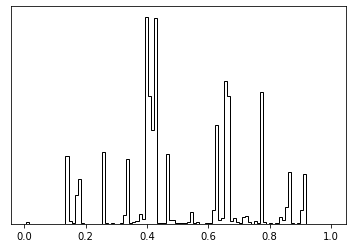

In [164]:
samples = np.load("files/results/samples_emcee.txt" ,  allow_pickle=True)
plt.hist(samples[:, 3], 100, color="k", histtype="step")
#plt.xlabel(r"$\theta_1$")
#plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);


In [168]:
samples.shape

(240000, 10)

In [136]:
autocorr_time = np.load("files/results/autocorr_time_emcee.txt" ,  allow_pickle=True)
autocorr_time

array([423.17156578, 583.93395984, 600.45008394, 446.47465559,
       600.43979306, 449.43914778, 605.65964543, 400.22024519,
       529.04925286, 411.48472675])

In [ ]:
acceptance_fraction = np.load("files/results/acceptance_fraction_emcee.txt" ,  allow_pickle=True)
acceptance_fraction

In [144]:
log_probs = np.load("files/results/log_probs.txt" ,  allow_pickle=True)
log_probs

array([-5597042.8429107 , -6058490.15452306, -8619627.28374162, ...,
        -109148.62934078,   -74867.23749369,  -301388.08785582])

In [113]:
alpha1, alpha2, a, c, b, d, lambda1, lambda2, omega, exit_nmp_val = fitted_params

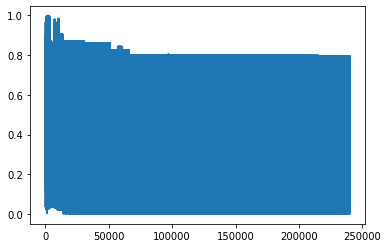

In [171]:
x = np.linspace(0, samples.shape[0], num = samples.shape[0])
plt.plot(x, samples[:,1])

### Comparing output (running stoch model with best parameters) against data

In [123]:
num_ss = 100
sim_stages = np.linspace(0,n-1,num_ss, dtype = int)
dt = .1  # Time step.
T = 10  # Total time.
tolerance = 1e-8

batch_num = 0
batch = 1
batch_nmp_num = [[] for i in range(batch)]

while batch_num < batch:
    trajs_list = []
    i = 0
    while i < nmp_numbers:
        xinit = nmp_list[i][0]
        yinit = nmp_list[i][1]
        single_cell_sim = em_cle(1, xinit, yinit, tolerance, dt , T, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, seed = batch_num)
        trajs_list.append(single_cell_sim)
        i+=1
    print("Embryo simulation complete: {} cells".format(nmp_numbers))

    num_nmps_time = []
    for i in range(num_ss) :
        nmp_counter = 0
        traj = np.squeeze(np.array(trajs_list))[:,:,sim_stages[i]]
        for cell in traj:
            if not ((cell[0] <= exit_nmp_val and cell[1] >= exit_nmp_val) or (cell[0] >= exit_nmp_val and cell[1] <= exit_nmp_val)):
                nmp_counter += 1
        num_nmps_time.append(nmp_counter)
    print("num_nmps_time", num_nmps_time)
    batch_nmp_num[batch_num].append(num_nmps_time)
    batch_num +=1

Embryo simulation complete: 182 cells
num_nmps_time [91, 96, 99, 109, 121, 125, 129, 133, 137, 137, 134, 136, 136, 132, 130, 141, 136, 120, 118, 126, 123, 116, 119, 114, 120, 119, 121, 114, 115, 113, 111, 111, 107, 104, 105, 104, 105, 104, 102, 99, 99, 100, 97, 98, 98, 98, 98, 96, 95, 95, 95, 95, 92, 90, 90, 90, 90, 90, 90, 90, 89, 89, 88, 87, 85, 84, 82, 79, 71, 70, 70, 65, 63, 62, 60, 57, 54, 51, 48, 48, 46, 45, 42, 33, 27, 26, 25, 21, 14, 11, 10, 6, 3, 2, 2, 1, 1, 1, 1, 1]


In [124]:
(num_nmps_time)[0:100]

[91,
 96,
 99,
 109,
 121,
 125,
 129,
 133,
 137,
 137,
 134,
 136,
 136,
 132,
 130,
 141,
 136,
 120,
 118,
 126,
 123,
 116,
 119,
 114,
 120,
 119,
 121,
 114,
 115,
 113,
 111,
 111,
 107,
 104,
 105,
 104,
 105,
 104,
 102,
 99,
 99,
 100,
 97,
 98,
 98,
 98,
 98,
 96,
 95,
 95,
 95,
 95,
 92,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 89,
 89,
 88,
 87,
 85,
 84,
 82,
 79,
 71,
 70,
 70,
 65,
 63,
 62,
 60,
 57,
 54,
 51,
 48,
 48,
 46,
 45,
 42,
 33,
 27,
 26,
 25,
 21,
 14,
 11,
 10,
 6,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1]

In [33]:
plt.plot(x[5:100],(num_nmps_time)[5:100], label = "Simulated")
plt.plot(x[5:100],data[5:100], color = 'r', label = "Data")

NameError: name 'x' is not defined

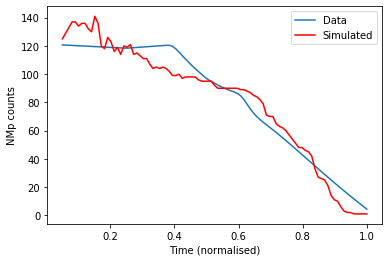

In [125]:
x = np.linspace(0,1,100)
plt.plot(x[5:100],data[5:100],label="Data")
plt.plot(x[5:100],(num_nmps_time)[5:100],label="Simulated", color = 'r')
plt.xlabel('Time (normalised)')
plt.ylabel('NMp counts')
plt.legend()

In [ ]:
samples = sampler.get_chain(flat=True)
print('samples')
print(samples.shape)
print(type(samples))
print(' ')
with open("samples_emcee.txt", "wb") as fp:   #Pickling
    pickle.dump(samples, fp)

log_probs = sampler.flatlnprobability
print('log_probs')
print(log_probs.shape)
print(type(log_probs))
print(' ')
with open("log_probs.txt", "wb") as fp:   #Pickling
    pickle.dump(log_probs, fp)
    
map_params = samples[np.argmax(sampler.flatlnprobability)]
print('map_params')
print(map_params.shape)
print(type(map_params))
print(' ')
with open("map_params_emcee.txt", "wb") as fp:   #Pickling
    pickle.dump(map_params, fp)
    
acceptance_fraction = sampler.acceptance_fraction
print('acceptance_fraction')
print(acceptance_fraction.shape)
print(type(acceptance_fraction))
print(' ')
with open("acceptance_fraction_emcee.txt", "wb") as fp:   #Pickling
    pickle.dump(acceptance_fraction, fp)
    
autocorr_time = sampler.get_autocorr_time(quiet=True)
print('autocorr_time')
print(autocorr_time.shape)
print(type(autocorr_time))
print(' ')
with open("autocorr_time_emcee.txt", "wb") as fp:   #Pickling
    pickle.dump(autocorr_time, fp)

In [129]:
myparams

array([2.05844943e-02, 9.65632033e-01, 4.52272889e-02, 3.30898025e-01,
       4.10382923e-01, 4.17411003e-01, 4.92825227e+00, 4.68364994e+00,
       1.70012427e+02, 2.91903166e-01])